In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2


2026-01-21 14:16:53.288664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769005013.508246      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769005013.580554      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769005014.111966      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769005014.112020      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769005014.112023      55 computation_placer.cc:177] computation placer alr

In [3]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256
IMG_CHANNELS = 3

def load_dataset(img_dir, mask_dir):
    img_list = sorted(os.listdir(img_dir))
    imgs = []
    masks = []
    
    for name in img_list:
        img_path  = os.path.join(img_dir, name)
        mask_path = os.path.join(mask_dir, name)
        
        if not os.path.exists(mask_path):
            print(f"Mask not found for {name}, skipping.")
            continue
        
        # load image
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = img / 255.0
        
        # load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)
        
        imgs.append(img)
        masks.append(mask)
    
    return np.array(imgs), np.array(masks)

X, y = load_dataset("/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/image", "/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask")


In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
def build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    
    inputs = tf.keras.layers.Input(input_shape)

    # Down
    c1 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D()(c1)

    c2 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D()(c2)

    c3 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D()(c3)

    c4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D()(c4)

    c5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(p4)
    c5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(c5)

    # Up
    u6 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(u8)
    c8 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, 2, strides=2, padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(u9)
    c9 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = tf.keras.Model(inputs, outputs)
    return model


In [6]:
model = build_unet()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=10
)


I0000 00:00:1769005198.105618      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/10


I0000 00:00:1769005207.730311     130 service.cc:152] XLA service 0x7deb1000aed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769005207.730374     130 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769005209.235950     130 cuda_dnn.cc:529] Loaded cuDNN version 91002


 3/71 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6807 - loss: 0.6852  

I0000 00:00:1769005217.938452     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step - accuracy: 0.7381 - loss: 0.5768 - val_accuracy: 0.7447 - val_loss: 0.4032
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8194 - loss: 0.3232 - val_accuracy: 0.9415 - val_loss: 0.1563
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9476 - loss: 0.1386 - val_accuracy: 0.9566 - val_loss: 0.1187
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9599 - loss: 0.1058 - val_accuracy: 0.9620 - val_loss: 0.0983
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9677 - loss: 0.0829 - val_accuracy: 0.9663 - val_loss: 0.0884
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9707 - loss: 0.0747 - val_accuracy: 0.9626 - val_loss: 0.0974
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9725 - loss: 0.0704 - val_accuracy: 0.9697 - val_loss: 0.0803
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9743 - loss: 0.0670 - val_accuracy: 0.9711 - val_loss: 

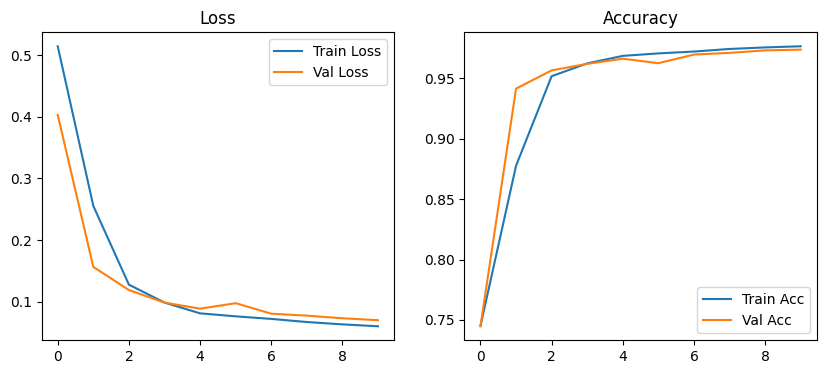

In [7]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Accuracy")
plt.show()
